# RHESSI (Reuven Ramaty High Energy Solar Spectroscopic Imager)
### Estudio de las llamaradas solares 
##### Descripcion:
Durante una llamarada, el gas situado en la atmósfera solar alcanza temperaturas de hasta 11 millones de grados Celsius, acelerando particulas a velocidades muy altas en el proceso. Esta aceleración ocasiona emisiones de luz en un rango que va desde el visible hasta rayos gamma, en donde dicha radiación no es apta para penetrar la atmósfera terrestre y por lo tanto no puede ser medida desde la tierra. Para poder registrar estas llamaradas y sus emisiones, se desarrolló la misión RHESSI mediante la creación de un satélite que midiera esta radiación y de esta manera lograr enteder el comportamiento de las llamaradas. El instrumento combina imagenes espectroscópicas del sol para caracterizar las energías presentes en cada llamarada. 

### Primer acercamiento con los datos
Para iniciar, se tomó la base de datos de la misión RHESSI de la NASA desde la página Kaggle [Solar Flares from RHESSI Mission](https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi) directamente como un archivo CSV. En esta página se encuentran 2 archivos referentes a los intervalos 2002-1016 y 2002-2018, pero en el estudio se considera el archivo con los datos completos (2002-2018).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm

# Se está trabajando en la rama testgh by @SOG


Para limpiar un poco la base de datos, se realiza una unión entre las columnas que contienen información acerca de la fecha y hora de inicio de la erupción, para generar una columna ***DateTime*** que luego se convierte en el index de los datos y descartar entonces la columna ***flare***. Luego, se crean nuevas columnas que guardan información como la energía promedio y la energía máxima a partir de ***energy.kev***, que facilitarán el ordenamiento de los datos cuando este se requiera. Además, como mecanismo de filtración, se crea una función la cual recibe un *DataFrame* y una lista que tiene como elementos las banderas que se quieren omitir de los datos, para retornar un *DataFrame* sin los eventos asociados a las banderas establecidas. Lo anterior con el objetivo de filtrar los datos para tomar solo los eventos asociados a procesos solares, cuando esto sea necesario. 

In [293]:
file_path = r"2002to2018.csv"  #2002to2016.csv
df = pd.read_csv(file_path)
# df = df.sort_values(by='duration.s', ascending=False).reset_index(drop=True)
# formatT = '%Y-%m-%d %H:%M:%S'

df['Datetime'] = pd.to_datetime(df['start.date'] +
                                ' ' + 
                                df['start.time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
# del df['flare']
del df['start.date']
del df['start.time']
del df['Datetime']

## CALCULO DE ENERGIAS

Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Eprom.append((float(result[0]) + float(result[1]))/2)

df['Eprom.kev'] = Eprom


### El dataFrame no contiene energías de 3-6 keV correspondientes a la radiación de fondo. Tanto la posición x,y 
### como la distancia radial son iguales a 0
df = df[df['radial'] < 4000]
df = df[df['active.region.ar'] < 2700]
df = df[df['energy.kev'] != '3-6']

def filtro(data, Lbanderas): # Filtro por bandera
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
# df['radioR'] = np.sqrt(df['x.pos.asec']**2 + df['y.pos.asec']**2)
df

,flare,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Eprom.kev
Datetime,,,,,,,,,,,,,,,,,
2002-02-12 21:29:56,2021213,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,18.5
2002-02-13 08:53:20,2021312,08:55:18,09:05:08,708,92,125352.0,25-50,-362,309,476,0,A1,P1,NaN,NaN,NaN,37.5
2002-02-13 12:29:32,2021313,12:30:58,12:33:24,232,26,16920.0,12-25,-905,-375,980,0,A1,P1,NaN,NaN,NaN,18.5
2002-02-13 23:31:56,2021355,23:34:06,23:52:56,1260,56,91896.0,12-25,-230,299,378,0,A1,P1,PE,Q1,NaN,18.5
2002-02-14 06:05:08,2021441,06:07:46,06:12:00,412,28,44304.0,12-25,-996,-82,999,0,A1,P1,NaN,NaN,NaN,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 14:53:32,18020901,14:55:22,14:58:32,300,13,3008.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,9.0
2018-02-09 15:45:28,18020902,15:46:54,15:52:36,428,28,9088.0,6-12,0,0,0,2699,A0,DF,P1,PE,Q2,9.0
2018-02-09 16:41:28,18020903,16:42:54,16:43:32,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,9.0


**Gráfica Q-Q** para la duración de la llamarada en comparación a una distribución chi cuadrada

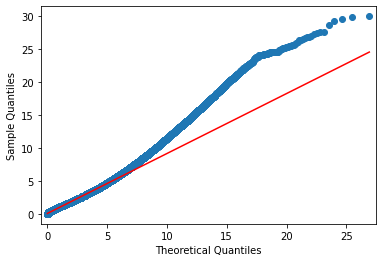

In [294]:
sm.qqplot(df['duration.s'], line='q', dist=stats.distributions.chi2, fit=True)
plt.show()

Text(0.5, 1.0, 'Distancia al polo negativo')

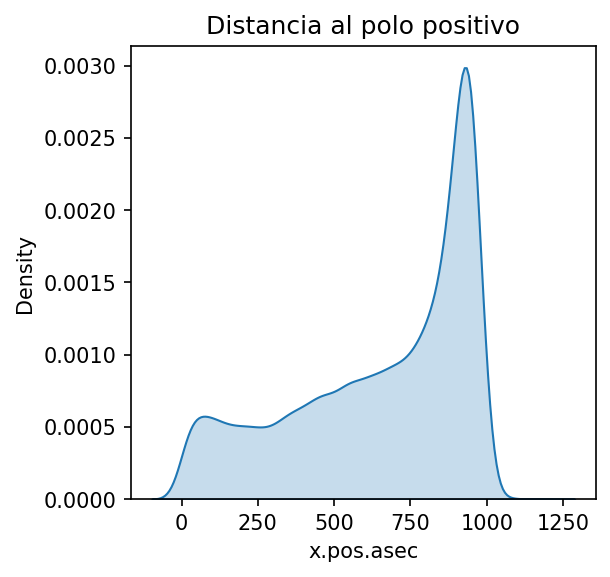

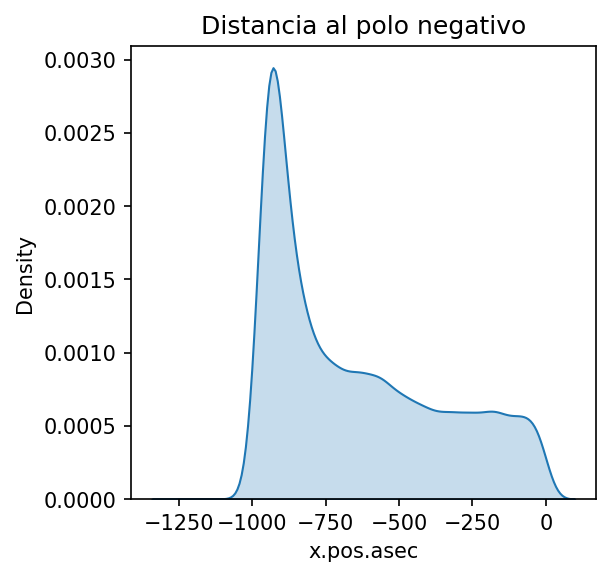

In [295]:
# dfpos = df[df['x.pos.asec'] > 0]
dfpos = df

dfpos = df[df['x.pos.asec'] > 0]
plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=dfpos.sort_values('Eprom.kev'), x='x.pos.asec',  fill=True)
plt.title('Distancia al polo positivo')

dfpos = df[df['x.pos.asec'] < 0]
# dfpos['x.pos.asec'] = np.abs(dfpos['x.pos.asec'])

plt.figure(figsize=(4,4), dpi = 150)
sns.kdeplot(data=dfpos.sort_values('Eprom.kev'), x='x.pos.asec',  fill=True)
plt.title('Distancia al polo negativo')

### Análisis primario de los datos
Como primer análisis a los datos, se busca estudiar si existe alguna relación lineal entre las columnas involucradas en la base de datos, y es por ello que se realiza una matriz de correlación. Esta matriz arroja como resultado una aparente correlación entre la cuenta total de picos y los picos por segundo, y se concluye también un comportamiento no lineal para el resto de columnas y se descarta un estudio multilineal para las demás columnas de la base de datos.

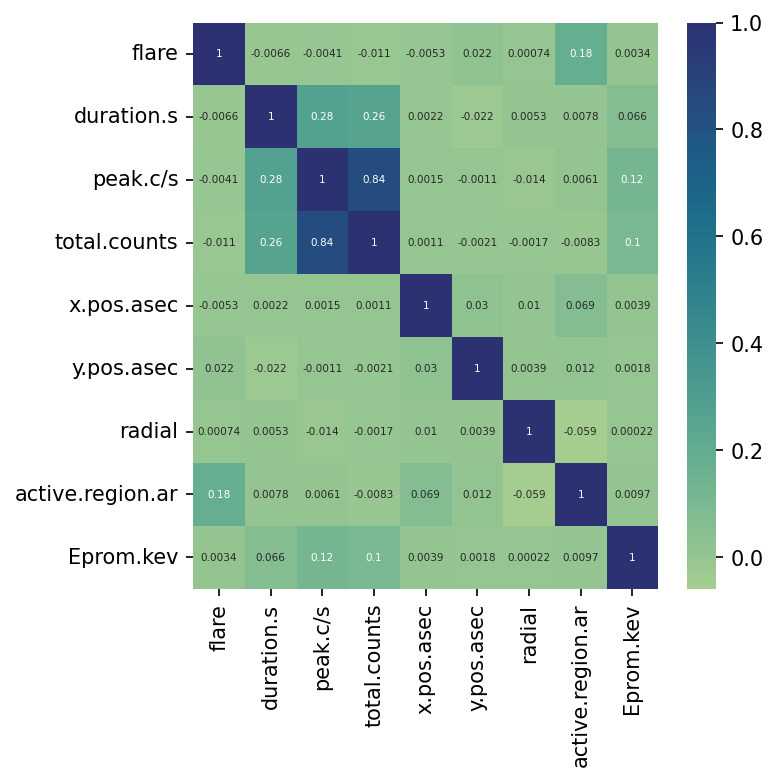

In [296]:
plt.figure(figsize=(5,5), dpi = 150)
matriz=df.corr(method='pearson')
sns.heatmap(matriz,cmap='crest',annot=True, annot_kws={'fontsize':5})
plt.savefig('img/matriz.png', dpi=300)

#### Histogramas
##### Se muestra la distribución de las erupciones en la superficie solar junto al histograma de la posición para cada ***(x,y)***
Con esta representación es posible ver como los eventos asociados a diferentes rangos de energía que ocurren en las capas exteriores de la atmósfera solar, son detectados por el satélite y como se distribuyen espacialmente. Se nota que eventos o llamaradas que emiten a una energía en el rango ultra-violeta (6-12 KeV) están distribuidos a través de toda la superficie solar, y que a medida que aumenta la energía emitida por las llamaradas, estas tienden a ubicarse justo en las zonas de mayor velocidad de rotación del sol.

ok


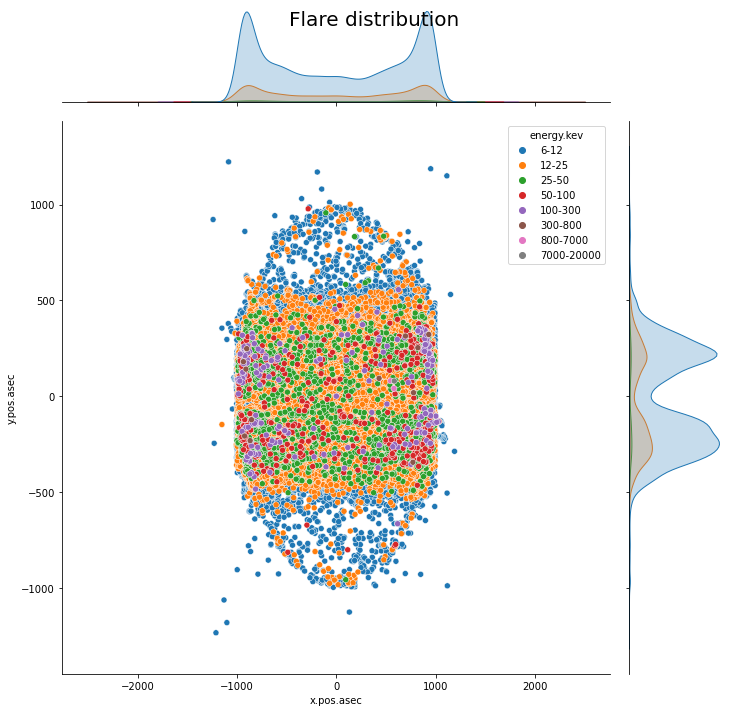

In [299]:
sns.jointplot(data=df.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec',
              hue='energy.kev', kind='scatter', height=10).fig.suptitle('Flare distribution', fontsize=20)
plt.savefig('img/G1.png', dpi = 300)
print('ok')

También es posible notar que las distribuciones de las posiciones espaciales de las llamaradas siguen una distribución partiendo del origen hacia alguno de los polos, tal que es simetrica en relación al otro polo, dependiendo del eje espacial.

#### Histograma de rango de energías
##### Se muestra como se distribuyen los eventos en relación a su energía emitida 

<AxesSubplot:xlabel='energy.kev', ylabel='count'>

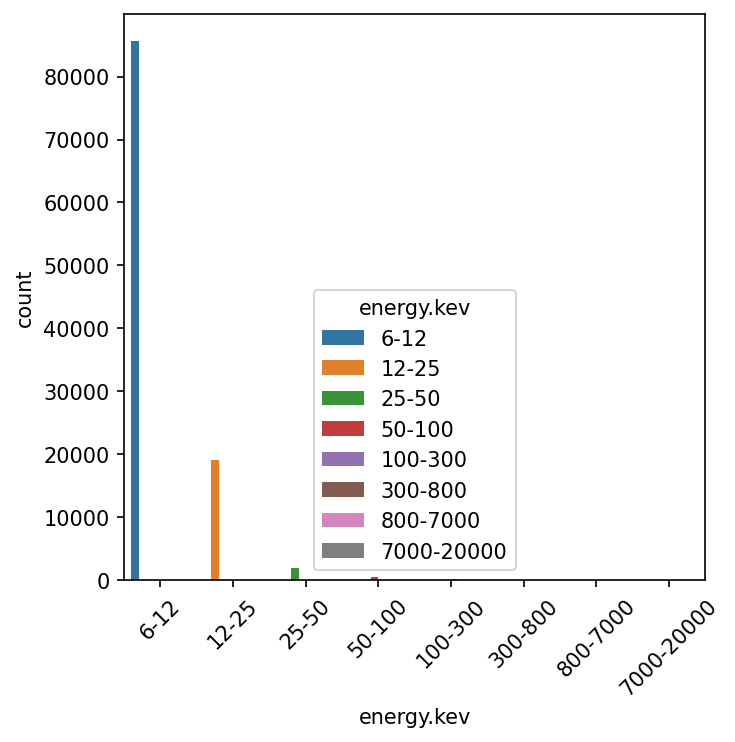

In [300]:
plt.figure(figsize=(5,5), dpi = 150)
plt.xticks(rotation=45)
sns.countplot(data=df.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')

#### Diagrama de caja y bigotes
##### Se grafica un boxplot para los datos de la posición en **Y**
La utilización de este tipo de gráficos es muy importante ya que dan una pista de como se encuentran distribuidos los datos.

Text(0.5, 1.0, 'Boxplot')

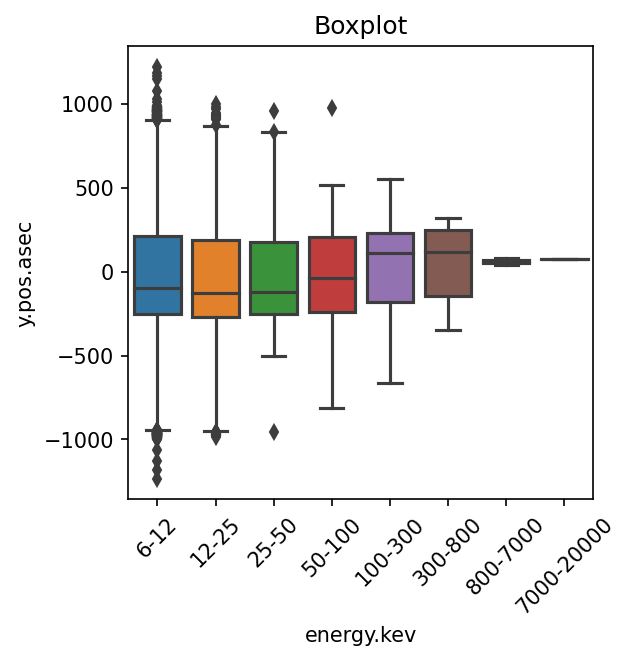

In [301]:
plt.figure(figsize=(4,4), dpi = 150)
sns.boxplot(data=df.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
plt.xticks(rotation=45)
plt.title('Boxplot')

### Datos nulos y filtrado
##### Se filtran los posibles valores erróneos de acuerdo a las banderas establecidas en el archivo README, o eventos no ocurridos en el sol

De acuerdo a los intereses del estudio, se selecionaron los eventos que contienen banderas **NS**, **P0** o **PE**, ya que estos corresponden a eventos no solares, eventos con posición válida, o eventos de partículas solares. Lo anterior mediante el uso de la función *filtro* mencionada anteriormente. La filtración de estos datos es de suma importancia debido a que permite trabajar solamente con los datos provenientes de la superficie solar.

In [97]:
# lista = ['NS','SD','SS','SE','DF','DR','ED','EE','ES','FE','FR','FS','GD','GE','GS','MR','P0','PS','PE']
lista = ['NS', 'P0', 'PE']
dataFiltro = filtro(df, lista)
dataFiltro # Este filtro ya no se utiliza

df.isnull().sum()
df.describe()

,flare,duration.s,peak.c/s,total.counts,x.pos.asec,y.pos.asec,radial,active.region.ar,Eprom.kev
count,1.092350e+05,109235.000000,109235.000000,1.092350e+05,109235.000000,109235.000000,109235.000000,109235.000000,109235.000000
mean,1.094926e+07,495.112629,210.728686,3.759476e+05,2.549082,-34.146226,716.249664,1052.361029,12.169332
std,9.749719e+06,431.987706,850.215148,3.111046e+06,711.111984,266.228925,254.716783,1370.049949,45.705290
min,2.021213e+06,8.000000,0.000000,8.000000e+00,-1242.000000,-1235.000000,0.000000,0.000000,9.000000
25%,4.110816e+06,212.000000,28.000000,2.268000e+04,-733.000000,-255.000000,522.000000,36.000000,9.000000
50%,1.112291e+07,368.000000,52.000000,5.716800e+04,-1.000000,-101.000000,789.000000,756.000000,9.000000
75%,1.403193e+07,628.000000,136.000000,1.730160e+05,742.000000,207.000000,950.000000,1618.000000,9.000000
max,1.412161e+08,4444.000000,113156.000000,4.355501e+08,1190.000000,1223.000000,1731.000000,9999.000000,13500.000000


### Aproximación utilizando una distribución normal a partir de datos logarítmicos
Al estudiar la distribución de los datos relacionados a la duración de las llamaradas, se ve un comportamiento interesante que se busca estudiar más a fondo al llevar esta variable a una escala logarítmica.

<AxesSubplot:xlabel='duration.s', ylabel='Count'>

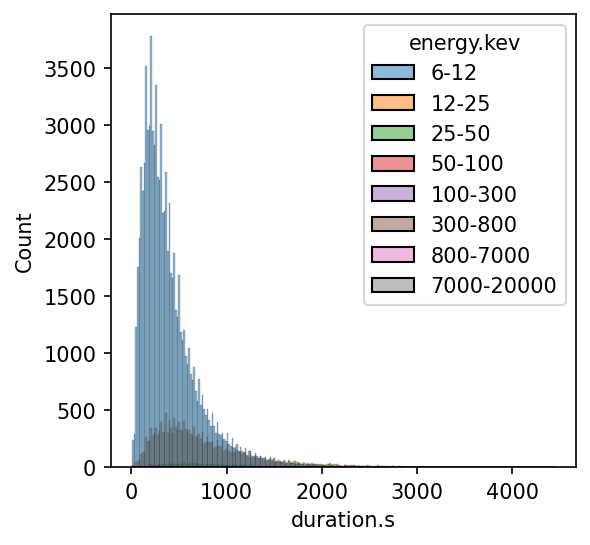

In [104]:
plt.figure(figsize=(4,4), dpi = 150)
# sns.kdeplot(data=df.sort_values('Eprom.kev'), x='duration.s', hue='energy.kev', fill=True)
sns.histplot(data=df.sort_values('Eprom.kev'), x='duration.s', hue='energy.kev')

Para implementar esta escala, es necesario crear una nueva columna que guarde el valor del logaritmo aplicada a la columna **duration.s**.

C:\Users\santi\anaconda\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


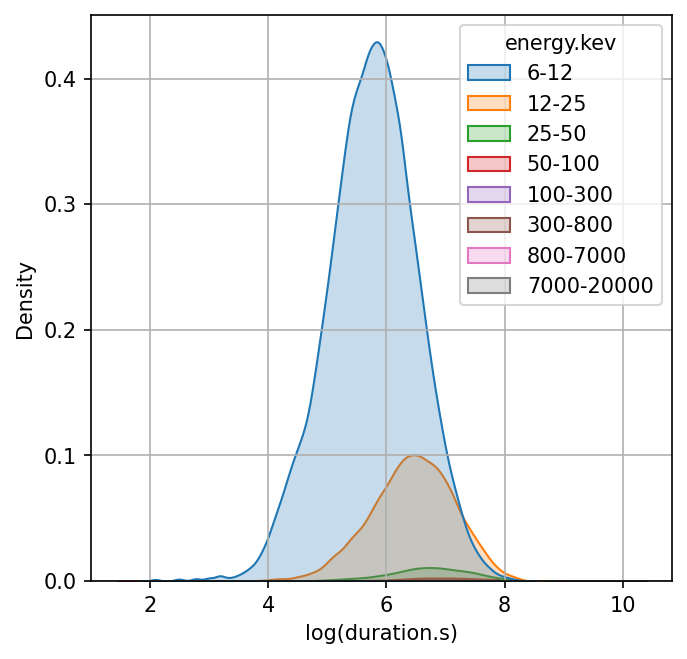

In [302]:
df['log(duration.s)'] = np.log(df['duration.s'])

plt.figure(figsize=(5,5), dpi = 150)
sns.kdeplot(data=df.sort_values('Eprom.kev'), x='log(duration.s)', hue='energy.kev', fill=True)
plt.grid()

En esta escala logarítmica se evidencia un poco más el comportamiento normal que presentan los datos, y es por esto que se procede a realizar un ajuste para encontrar la función de distribución.

('Los parámetros son: ', (5.892620443729158, 0.8073011982989905))

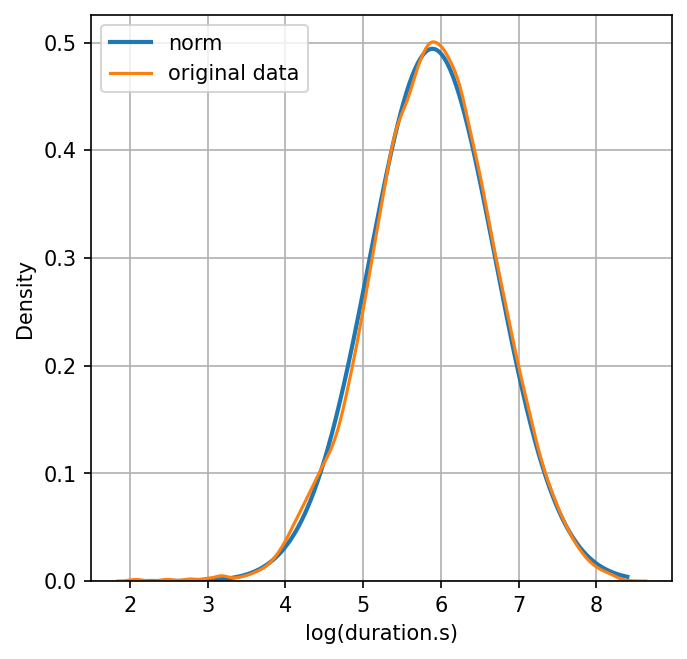

In [111]:
distr = stats.norm

parametros = distr.fit(data=df['log(duration.s)'])
# nombre_parametros = [p for p in inspect.signature(distr._pdf).parameters \
#                      if not p=='x'] + ["loc","scale"]
# parametros_dict = dict(zip(nombre_parametros, parametros))

x_hat = np.linspace(min(df['log(duration.s)']), max(df['log(duration.s)']), num=1000)
y_hat = distr.pdf(x_hat, *parametros)
plt.figure(figsize=(5,5), dpi = 150)
plt.plot(x_hat, y_hat, linewidth=2, label=distr.name)


# plt.figure(figsize=(5,5), dpi = 150)
sns.kdeplot(data=df.sort_values('Eprom.kev'), x='log(duration.s)', label='original data')
plt.legend()
plt.grid()
'Los parámetros son: ',parametros

De esta manera, se encuentra la distribución de densidad para la duración de llamaradas solares:

# $f(x) = \frac{1}{\sigma\cdot\sqrt{2\pi}}\cdot e^{-\frac{1}{2}(\frac{\ln(x)-\mu}{\sigma})^2}$
#### donde $\mu \approx 5.89$ y $\sigma \approx 0.81$

Prueba QQ de la duración en comparación a una distribución chi cuadrada

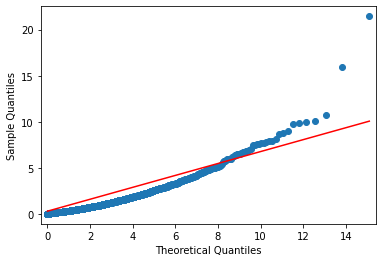

In [494]:
# dfP = dataFiltro[dataFiltro['energy.kev'] != '50-100'] # Filtrar por energías si es necesario


# sm.qqplot?
sm.qqplot(dfP['total.counts'], line='s', dist=stats.distributions.chi2, fit=True)
plt.show()

# plt.figure(figsize=(5,5), dpi = 150)
# sns.boxplot(data=df.sort_values('Eprom.kev'), x='energy.kev', y="y.pos.asec")
# plt.title('Boxplot')

# sns.jointplot(data=df.sort_values('Eprom.kev'), x='x.pos.asec', y='y.pos.asec', hue='energy.kev', kind='scatter', height=10, 
#               xlim=(-1500, 1500), ylim=(-1500, 1500)).fig.suptitle('Flare distribution', fontsize=20)

# plt.figure(figsize=(5,5), dpi = 150)
# sns.countplot(data=df.sort_values('Eprom.kev'), x="energy.kev", hue='energy.kev')



##### **Cantidad de llamaradas por año**

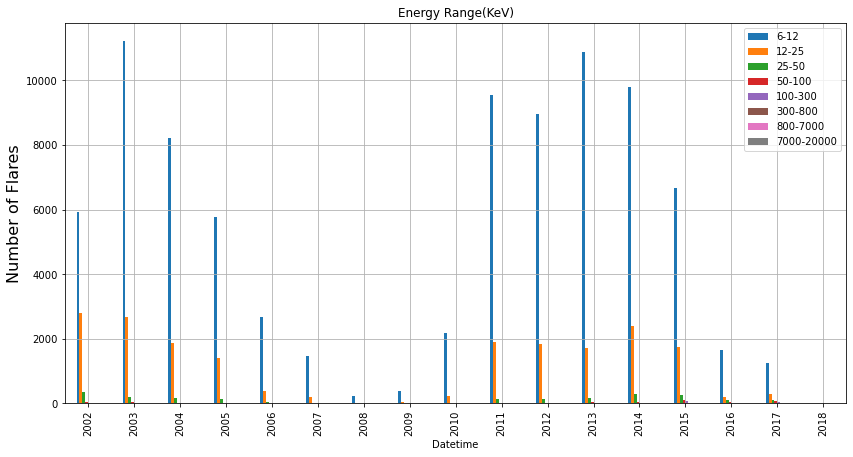

In [89]:
df['value'] = pd.Categorical(df['energy.kev'], ["6-12", "12-25", "25-50", "50-100",
                                                '100-300', '300-800', '800-7000', '7000-20000'])
df.groupby([df.index.year])['value'].value_counts().unstack().plot(kind='bar', figsize=(14,7), title='Energy Range(KeV)'
                                                                       , style='ggplot', grid=True)
df = df.drop(['value'], axis=1)
plt.ylabel('Number of Flares', fontsize=16)
plt.legend(loc='best', prop={'size': 10})

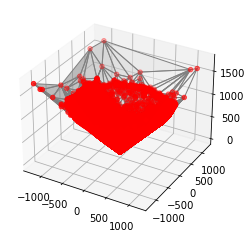

In [133]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
ax.plot_trisurf(df['x.pos.asec'], df['y.pos.asec'], df['radial'], color='white', edgecolors='grey', alpha=0.5) 
ax.scatter(df['x.pos.asec'], df['y.pos.asec'], df['radial'], c='red') 
plt.show()

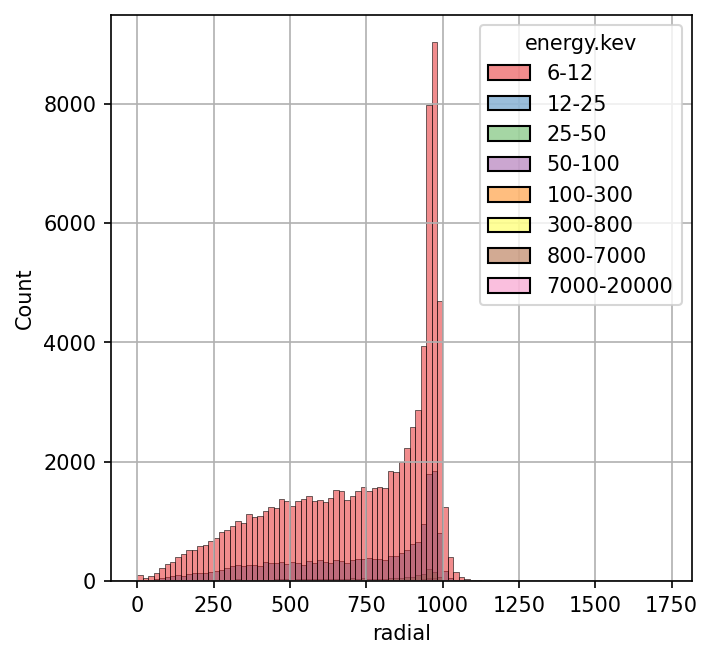

In [135]:
plt.figure(figsize=(5,5), dpi = 150)
sns.histplot(data=df.sort_values('Eprom.kev'), x='radial', hue='energy.kev', fill=True, palette='Set1')
plt.grid()

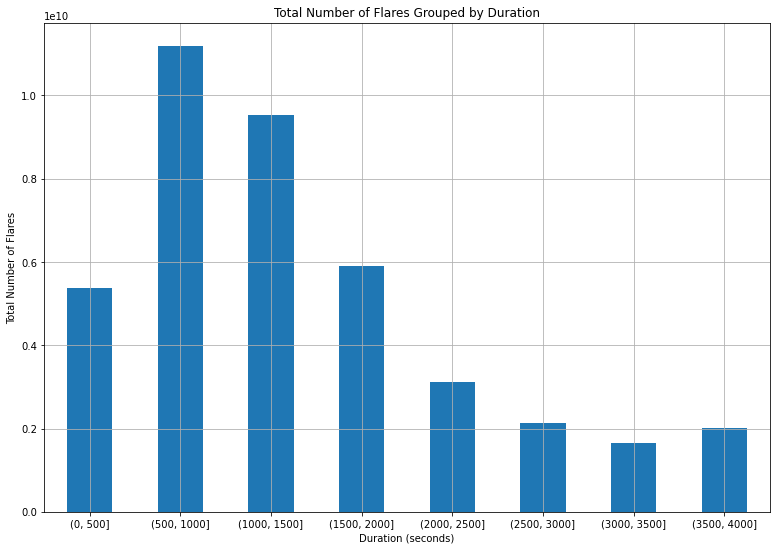

In [140]:
f, ax = plt.subplots(figsize=(13, 9))
dfnew = df.loc[:, ['duration.s', 'total.counts']]
dfnew2 = dfnew.groupby(pd.cut(dfnew["duration.s"], range(0, max(df['duration.s']), 500))).sum()
ax = dfnew2["total.counts"].plot(kind='bar', title="Total Number of Flares Grouped by Duration")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

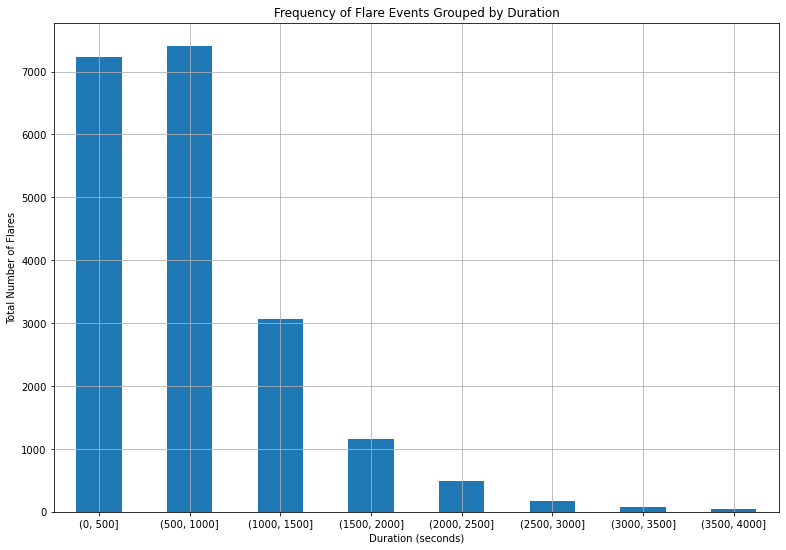

In [146]:
f, ax = plt.subplots(figsize=(13, 9))
dfnew2 = dfP.groupby(pd.cut(df["duration.s"], range(0, max(df['duration.s']), 500))).count()
ax = dfnew2["total.counts"].plot(kind='bar', title="Frequency of Flare Events Grouped by Duration")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Total Number of Flares")
plt.xticks(rotation=0)
plt.grid()
plt.show()

#### **Machine learning** para todas las energías
Se realiza una preparación de los datos

In [306]:
dfpred = df.drop(['flag.1', 'flag.2', 'flag.3', 'flag.4', 'flag.5',
                   'end', 'peak', 'Eprom.kev'], axis=1)


# dfpred.loc[:, 'energy.kev']

# var = pd.get_dummies(data=dfpred, columns = ['energy.kev'])

dfpred['year'] = dfpred.index.year
dfpred['month'] = dfpred.index.month
dfpred['day'] = dfpred.index.day
# dfpred = dfpred.set_index('flare')
dfpred = dfpred.drop(['duration.s', 'flare'], axis=1)

category = {'6-12': 1, '12-25': 2, '25-50': 3, '50-100': 4, 
            '100-300': 5, '300-800': 6, '800-7000': 7, '7000-20000': 8}

dfpred['energy.kev'] = dfpred['energy.kev'].map(category)

dfpred['energy.kev'].value_counts()

# df['a'] = df
dfpred

,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,log(duration.s),year,month,day
Datetime,,,,,,,,,,,
2002-02-12 21:29:56,136,167304.0,2,592,-358,692,0,6.568078,2002,2,12
2002-02-13 08:53:20,92,125352.0,3,-362,309,476,0,6.562444,2002,2,13
2002-02-13 12:29:32,26,16920.0,2,-905,-375,980,0,5.446737,2002,2,13
2002-02-13 23:31:56,56,91896.0,2,-230,299,378,0,7.138867,2002,2,13
2002-02-14 06:05:08,28,44304.0,2,-996,-82,999,0,6.021023,2002,2,14
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 14:53:32,13,3008.0,1,-345,-38,347,2699,5.703782,2018,2,9
2018-02-09 15:45:28,28,9088.0,1,0,0,0,2699,6.059123,2018,2,9
2018-02-09 16:41:28,18,2888.0,1,-345,-38,347,2699,4.820282,2018,2,9


Se separan la base de datos en un conjunto de entrenamiento y otro de prueba

In [311]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = dfpred.drop(['energy.kev'], axis = 1)
y = dfpred['energy.kev'] #Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

# scores = cross_val_score(model, dfpred.drop(['energy.kev'], axis=1), dfpred['energy.kev'], cv=10)
# scores
dfpred

,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,log(duration.s),year,month,day
Datetime,,,,,,,,,,,
2002-02-12 21:29:56,136,167304.0,2,592,-358,692,0,6.568078,2002,2,12
2002-02-13 08:53:20,92,125352.0,3,-362,309,476,0,6.562444,2002,2,13
2002-02-13 12:29:32,26,16920.0,2,-905,-375,980,0,5.446737,2002,2,13
2002-02-13 23:31:56,56,91896.0,2,-230,299,378,0,7.138867,2002,2,13
2002-02-14 06:05:08,28,44304.0,2,-996,-82,999,0,6.021023,2002,2,14
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 14:53:32,13,3008.0,1,-345,-38,347,2699,5.703782,2018,2,9
2018-02-09 15:45:28,28,9088.0,1,0,0,0,2699,6.059123,2018,2,9
2018-02-09 16:41:28,18,2888.0,1,-345,-38,347,2699,4.820282,2018,2,9


##### BOXCOX

(NormaltestResult(statistic=1.3601208223655488, pvalue=0.5065863879583006),
 1.396169804008606)

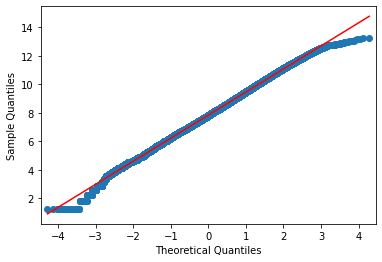

In [12]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import shapiro 

fitted_data, fitted_lambda = stats.boxcox(dfpred['log(duration.s)'])


sm.qqplot(fitted_data, line='s', dist=stats.distributions.norm)
# sm.qqplot(df['duration.s'], line='s', dist=stats.distributions.norm)
# plt.show()

normaltest(fitted_data), fitted_lambda

pvalue $\approx$ 0.5, por lo tanto no se rechaza la hipótesis de que siga una distribución normal

In [308]:
### Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve

modelTree = DecisionTreeClassifier()
modelTree.fit(X_train, y_train)
score = modelTree.score(X_test, y_test)
scoreTr = modelTree.score(X_train, y_train)

score, scoreTr

(0.8041531070819774, 1.0)

In [309]:
### Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

modelBos = RandomForestClassifier()
modelBos.fit(X_train, y_train)
score = modelBos.score(X_test, y_test)
scoreTr = modelBos.score(X_train, y_train)

score, scoreTr

(0.8630404463040446, 0.9999601508952766)

#### Matriz de confusión

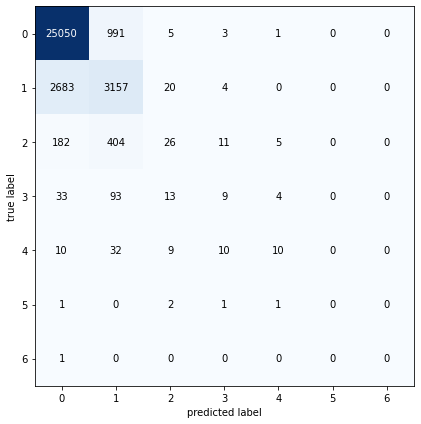

In [489]:
# Construida a partir del randomForest
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = modelBos.predict(X_test)
matriz = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_mat = matriz, figsize=(6,6), show_normed = False)
plt.tight_layout()

#### **ML** con las energías de mayor resolución (capturadas por la mission)

In [290]:
energy1 = df[df['energy.kev'] == '6-12']
energy2 = df[df['energy.kev'] == '12-25']
energy3 = df[df['energy.kev'] == '25-50']

dfene = pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
dfene = dfene[dfene['active.region.ar'] < 2700]

# dfpred_energy['year'] = dfpred_energy.index.year
# dfpred_energy['month'] = dfpred_energy.index.month
# dfpred_energy['day'] = dfpred_energy.index.day

dfpred_energy = dfene.drop(['flag.1', 'flag.2', 'flag.3', 'flag.4', 'flag.5',
                   'end', 'peak', 'Eprom.kev', 'flare', 'duration.s', 'active.region.ar'], axis=1)


category = {'6-12': 1, '12-25': 2, '25-50': 3}

dfpred_energy['energy.kev'] = dfpred_energy['energy.kev'].map(category)

dfpred_energy

,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,log(duration.s)
Datetime,,,,,,,
2002-02-12 21:29:56,136,167304.0,2,592,-358,692,6.568078
2002-02-13 08:53:20,92,125352.0,3,-362,309,476,6.562444
2002-02-13 12:29:32,26,16920.0,2,-905,-375,980,5.446737
2002-02-13 23:31:56,56,91896.0,2,-230,299,378,7.138867
2002-02-14 06:05:08,28,44304.0,2,-996,-82,999,6.021023
...,...,...,...,...,...,...,...
2018-02-09 14:53:32,13,3008.0,1,-345,-38,347,5.703782
2018-02-09 15:45:28,28,9088.0,1,0,0,0,6.059123
2018-02-09 16:41:28,18,2888.0,1,-345,-38,347,4.820282


In [220]:
from sklearn.model_selection import train_test_split

X_energy = dfpred_energy.drop(['energy.kev', 'active.region.ar'], axis = 1)
y_energy = dfpred_energy['energy.kev'] #Target

X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(X_energy, y_energy, test_size=0.3, random_state=777)

dfpred_energy

,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar
Datetime,,,,,,,
2002-02-12 21:29:56,136,167304.0,2,592,-358,692,0
2002-02-13 08:53:20,92,125352.0,3,-362,309,476,0
2002-02-13 12:29:32,26,16920.0,2,-905,-375,980,0
2002-02-13 23:31:56,56,91896.0,2,-230,299,378,0
2002-02-14 06:05:08,28,44304.0,2,-996,-82,999,0
...,...,...,...,...,...,...,...
2018-02-09 14:53:32,13,3008.0,1,-345,-38,347,2699
2018-02-09 15:45:28,28,9088.0,1,0,0,0,2699
2018-02-09 16:41:28,18,2888.0,1,-345,-38,347,2699


(0.8554224385373768, 0.9999598860764571)

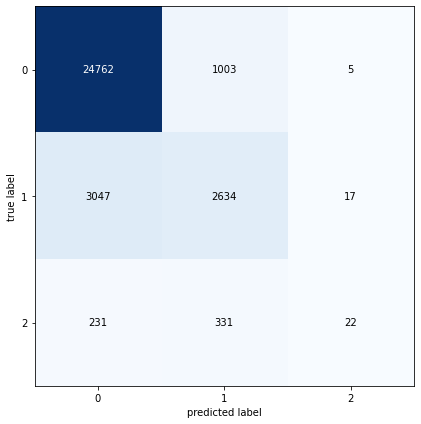

In [221]:
#### RandomForest

from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

modelBos = RandomForestClassifier()
modelBos.fit(X_train_energy, y_train_energy)
score = modelBos.score(X_test_energy, y_test_energy)
scoreTr = modelBos.score(X_train_energy, y_train_energy)

y_pred_energy = modelBos.predict(X_test_energy)
matriz = confusion_matrix(y_test_energy, y_pred_energy)

plot_confusion_matrix(conf_mat = matriz, figsize=(6,6), show_normed = False)
plt.tight_layout()

score, scoreTr

(0.8076875077998252, 1.0)

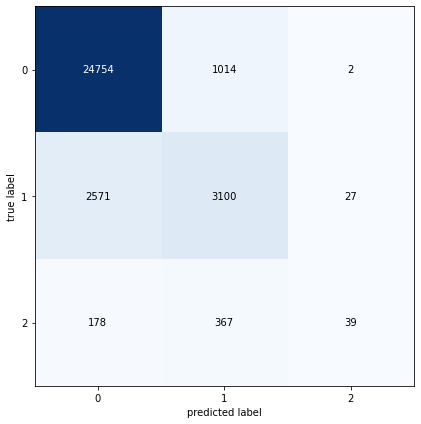

In [102]:
### Decision Tree

from sklearn.tree import DecisionTreeClassifier

modelTree = DecisionTreeClassifier()
modelTree.fit(X_train_energy, y_train_energy)
score = modelTree.score(X_test_energy, y_test_energy)
scoreTr = modelTree.score(X_train_energy, y_train_energy)

y_pred_energy = modelBos.predict(X_test_energy)
matriz = confusion_matrix(y_test_energy, y_pred_energy)

plot_confusion_matrix(conf_mat = matriz, figsize=(6,6), show_normed = False)
plt.tight_layout()

from sklearn.grid_search import GridSearchCVscore, scoreTr

In [285]:
dftes.set_index('flare')

,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Eprom.kev,log(duration.s)
flare,,,,,,,,,,,,,,,,,
2021213,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,18.5,6.568078
2021312,08:55:18,09:05:08,708,92,125352.0,25-50,-362,309,476,0,A1,P1,NaN,NaN,NaN,37.5,6.562444
2021313,12:30:58,12:33:24,232,26,16920.0,12-25,-905,-375,980,0,A1,P1,NaN,NaN,NaN,18.5,5.446737
2021355,23:34:06,23:52:56,1260,56,91896.0,12-25,-230,299,378,0,A1,P1,PE,Q1,NaN,18.5,7.138867
2021441,06:07:46,06:12:00,412,28,44304.0,12-25,-996,-82,999,0,A1,P1,NaN,NaN,NaN,18.5,6.021023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18020901,14:55:22,14:58:32,300,13,3008.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,9.0,5.703782
18020902,15:46:54,15:52:36,428,28,9088.0,6-12,0,0,0,2699,A0,DF,P1,PE,Q2,9.0,6.059123
18020903,16:42:54,16:43:32,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,9.0,4.820282


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

poly_model = make_pipeline(PolynomialFeatures(7),LinearRegression())

# .set_index('flare')
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),LinearRegression(**kwargs))

# dftes['radial'].plot()
# plt.show()

param_grid = {'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)


grid.fit(dfpred.drop(['log(duration.s)'], axis=1), dfpred['log(duration.s)'])

grid.best_params_


# plt.scatter(dftes.index, dftes['radial'], s=0.05)
# plt.show()

C:\Users\santi\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\santi\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = m